![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Medical_Language_Models/Medicare_Risk_Adjustment_Use_Case.ipynb)

## Medicare Risk Adjustment:
In the United States, the Centers for Medicare & Medicaid Services sets reimbursement for private Medicare plan sponsors based on the assessed risk of their beneficiaries. Information found in unstructured medical records may be more indicative of member risk than existing structured data, creating more accurate risk pools.

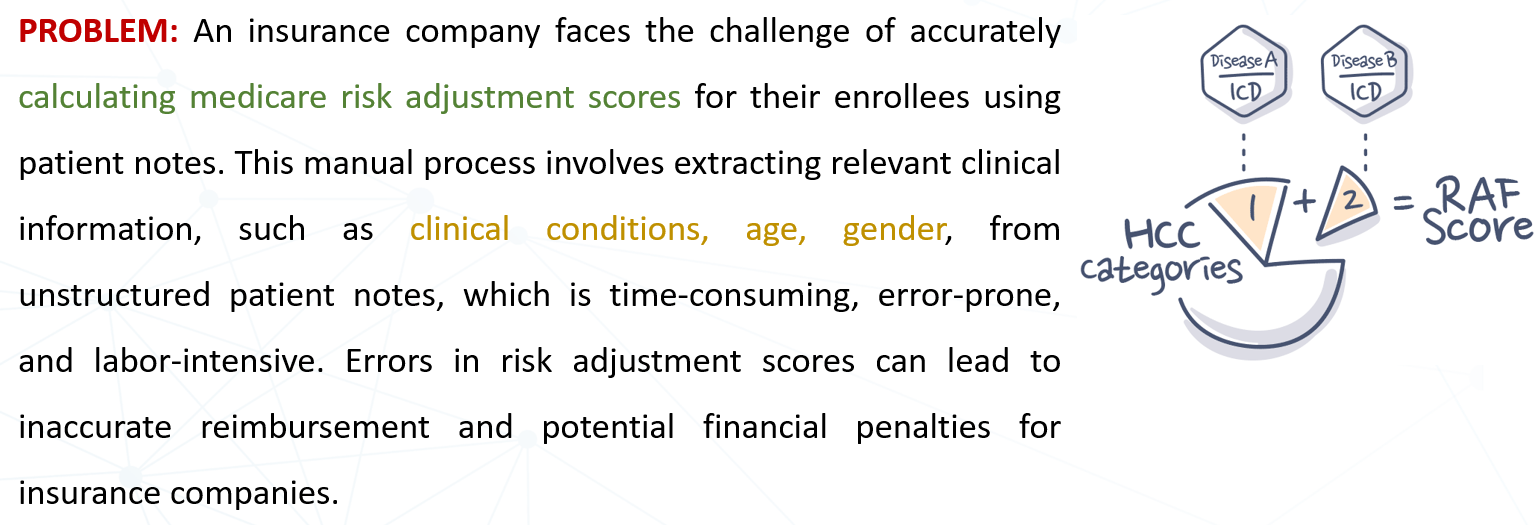

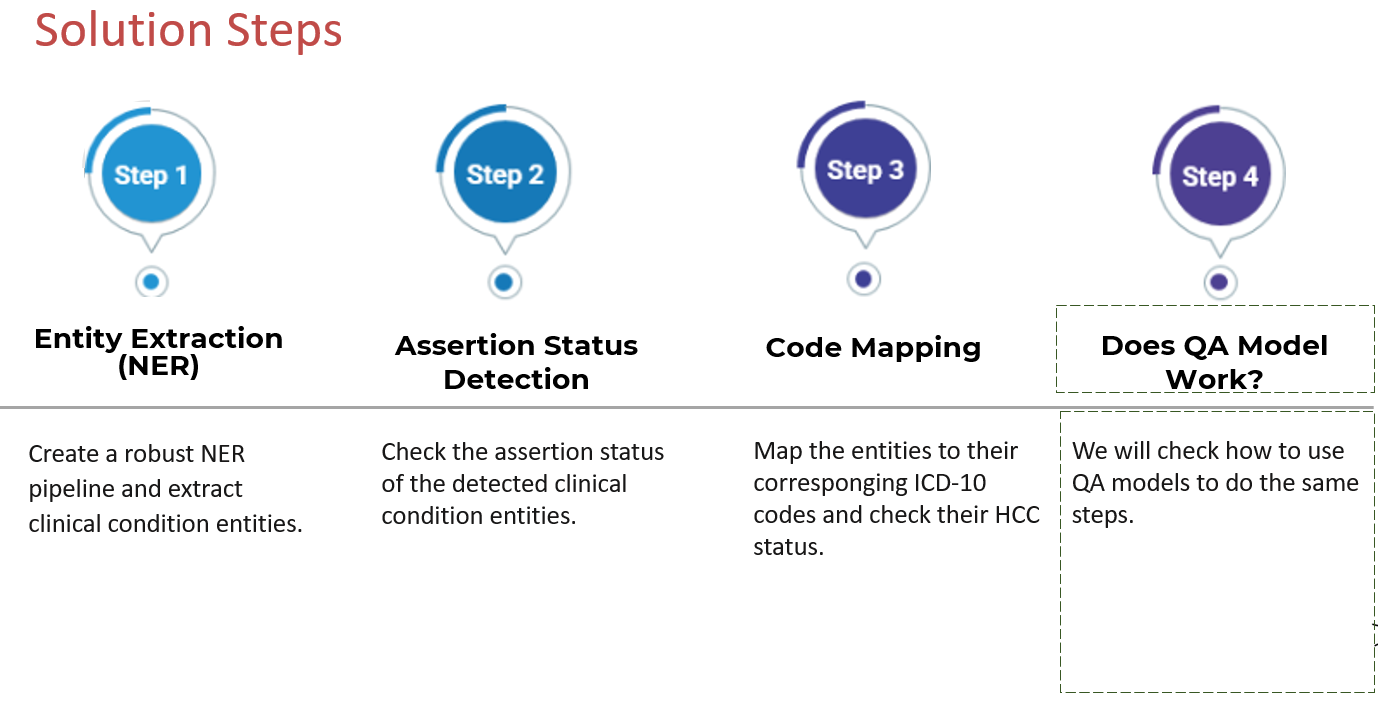

## ⚒️ Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install -q johnsnowlabs

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, medical

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.settings.enforce_versions=True
nlp.install(refresh_install=True)

In [ ]:
from johnsnowlabs import nlp, medical
import pandas as pd
import json
import warnings
warnings.filterwarnings('ignore')

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

👌 Detected license file /content/5.4.1.spark_nlp_for_healthcare.json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==5.4.1, 💊Spark-Healthcare==5.4.1, running on ⚡ PySpark==3.4.0


In [ ]:
spark

In [ ]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql as SQL
from pyspark import keyword_only

## ⚡ Healthcare NLP for Data Scientists Course

➡️ If you are not familiar with the components in this notebook, you can check [Healthcare NLP for Data Scientists Udemy Course](https://www.udemy.com/course/healthcare-nlp-for-data-scientists/) and the [MOOC Notebooks](https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/Spark_NLP_Udemy_MOOC/Healthcare_NLP) for each components.

## ⏬ Downloading oncology notes
In this notebook we will use the clinical notes extracted from www.mtsamples.com.

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/healthcare-nlp/data/mt_oncology_10.zip
!unzip -q mt_oncology_10.zip

In [ ]:
df = spark.sparkContext.wholeTextFiles('mt_oncology_10/mt_note_*.txt').toDF().withColumnRenamed('_1','path').withColumnRenamed('_2','text')
path_array = F.split(df['path'], '/')
df = df.withColumn('filename', path_array.getItem(F.size(path_array)- 1)).select(['filename', 'text'])

df.show(truncate=50)

+--------------+--------------------------------------------------+
|      filename|                                              text|
+--------------+--------------------------------------------------+
|mt_note_01.txt|\nMedical Specialty:Hematology - Oncology\nSamp...|
|mt_note_02.txt|Medical Specialty:Hematology - Oncology\nSample...|
|mt_note_03.txt|Medical Specialty:Hematology - Oncology\nSample...|
|mt_note_04.txt|Medical Specialty:Hematology - Oncology\nSample...|
|mt_note_05.txt|Medical Specialty:Hematology - Oncology\nSample...|
|mt_note_06.txt|Medical Specialty:Hematology - Oncology\nSample...|
|mt_note_07.txt|Medical Specialty:Hematology - Oncology\nSample...|
|mt_note_08.txt|Medical Specialty:Hematology - Oncology\nSample...|
|mt_note_09.txt|Medical Specialty:Hematology - Oncology\nSample...|
|mt_note_10.txt|Medical Specialty:Hematology - Oncology\nSample...|
+--------------+--------------------------------------------------+



In [ ]:
sample_text = df.limit(2).select("text").collect()[1][0]
print(sample_text)

Medical Specialty:Hematology - Oncology
Sample Name: Mullerian Adenosarcoma
Description: Discharge summary of a patient presenting with a large mass aborted through the cervix.
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS:  Mullerian adenosarcoma.
HISTORY OF PRESENT ILLNESS:  The patient is a 56-year-old presenting with a large mass aborted through the cervix.
PHYSICAL EXAM:CHEST: Clear. There is no heart murmur. ABDOMEN: Nontender.
PELVIC: There is a large mass in the vagina.
HOSPITAL COURSE:  The patient went to surgery on the day of admission. The postoperative course was marked by fever and ileus. The patient regained bowel function. She was discharged on the morning of the seventh postoperative day.
OPERATIONS:  July 25, 2006: Total abdominal hysterectomy, bilateral salpingo-oophorectomy.
DISCHARGE CONDITION:  Stable.
PLAN:  The patient will remain at rest initially with progressive ambulation thereafter. She will avoid lifting, driving, stairs, or intercourse. She wi

# 📌 Problem Solving


## 🎊 All-In-One Pipeline

We will create an all-in-one pipeline that will contain all the models we have. Here are the steps that we will follow:

📍 Extract `oncological`, `Disease_Syndrome_Disorder` and `Heart_Disease` entities from the clinical notes using NER model. We used just one NER model here but you can add any models into your pipeline to make it more robust.

📍 Assing their assertion status using assertion model, and filter the `Present` ones only.

📍 Get their ICD-10 codes using resolver model to map HCC status and scores.

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = nlp.SentenceDetectorDLModel.pretrained()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# ner_oncology
ner_oncology = medical.NerModel.pretrained("ner_oncology","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("ner_oncology")

ner_oncology_converter = medical.NerConverterInternal()\
    .setInputCols(["sentence","token","ner_oncology"])\
    .setOutputCol("ner_oncology_chunk")\
    .setWhiteList(['Cancer_Dx', 'Metastasis'])

jsl_ner = medical.NerModel.pretrained("ner_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_jsl")

jsl_ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_jsl"]) \
    .setOutputCol("ner_jsl_chunk")\
    .setWhiteList(['Cerebrovascular_Disease', 'Communicable_Disease', 'Diabetes',
                   'Disease_Syndrome_Disorder', 'Heart_Disease', 'Hyperlipidemia', 'Hypertension',
                   'Kidney_Disease', 'Obesity', 'Oncological', 'Pregnancy', 'Psychological_Condition'
                  ])

chunk_merger = medical.ChunkMergeApproach()\
    .setInputCols(["ner_oncology_chunk", "ner_jsl_chunk"])\
    .setOutputCol("ner_chunk")\
    .setSelectionStrategy("Sequential")

clinical_assertion = medical.AssertionDLModel.pretrained("assertion_oncology", "en", "clinical/models") \
    .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")

assertion_filterer = medical.AssertionFilterer()\
    .setInputCols("sentence","ner_chunk","assertion")\
    .setOutputCol("assertion_chunk")\
    .setCaseSensitive(False)\
    .setWhiteList(["Present"])

c2doc = nlp.Chunk2Doc()\
    .setInputCols("assertion_chunk")\
    .setOutputCol("assertion_chunk_doc")

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli",'en','clinical/models')\
    .setInputCols(["assertion_chunk_doc"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

icd10_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models")\
    .setInputCols(["sbert_embeddings"])\
    .setOutputCol("icd10_code")\
    .setDistanceFunction("EUCLIDEAN")\
    .setReturnCosineDistances(True)


all_pipeline = nlp.Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        ner_oncology,
        ner_oncology_converter,
        jsl_ner,
        jsl_ner_converter,
        chunk_merger,
        clinical_assertion,
        assertion_filterer,
        c2doc,
        sbert_embedder,
        icd10_resolver
])

data_ner = spark.createDataFrame([[""]]).toDF("text")
model = all_pipeline.fit(data_ner)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_oncology download started this may take some time.
[OK!]
ner_jsl download started this may take some time.
[OK!]
assertion_oncology download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
[OK!]


🎳 We can transform the data. In path column, we have long path. Instead we will use filename column. Every file name refers to different patient.


In [ ]:
result_sdf = model.transform(df)

🎉 Let's see how our model extracted PRESENT entitites and assign ICD-10 Codes on the sample text.

In [ ]:
light_model = nlp.LightPipeline(model)

light_result = light_model.fullAnnotate(sample_text)

vis = nlp.viz.EntityResolverVisualizer()

# Change color of an entity label
# vis.set_label_colors({'Oncological':'#008080'})

vis.display(light_result[0], 'assertion_chunk', 'icd10_code')

In [ ]:
ner_df = result_sdf.select("filename", F.explode(F.arrays_zip(result_sdf.ner_chunk.result,
                                                              result_sdf.ner_chunk.metadata)).alias("cols")) \
                   .select("filename", F.expr("cols['0']").alias("chunk"),
                                       F.expr("cols['1']['entity']").alias("label")
                          ).toPandas()

ner_df.head(10)

,filename,chunk,label
0,mt_note_01.txt,breast cancer,Cancer_Dx
1,mt_note_01.txt,breast cancer,Cancer_Dx
2,mt_note_01.txt,dysplasia,Disease_Syndrome_Disorder
3,mt_note_01.txt,cancer,Cancer_Dx
4,mt_note_02.txt,Name: Mullerian Adenosarcoma,Oncological
5,mt_note_02.txt,Mullerian adenosarcoma,Cancer_Dx
6,mt_note_02.txt,Mullerian adenosarcoma,Cancer_Dx
7,mt_note_03.txt,leiomyosarcoma,Cancer_Dx
8,mt_note_03.txt,pulmonary embolism,Disease_Syndrome_Disorder
9,mt_note_03.txt,subdural hematoma,Cerebrovascular_Disease


In [ ]:
assertion_df = result_sdf.select("filename", F.explode(F.arrays_zip(result_sdf.ner_chunk.result,
                                                                    result_sdf.ner_chunk.metadata,
                                                                    result_sdf.assertion.result)).alias("cols")) \
                         .select("filename", F.expr("cols['0']").alias("chunk"),
                                             F.expr("cols['1']['entity']").alias("label"),
                                             F.expr("cols['2']").alias("assertion")
                                ).toPandas()

assertion_df.head(10)

,filename,chunk,label,assertion
0,mt_note_01.txt,breast cancer,Cancer_Dx,Family
1,mt_note_01.txt,breast cancer,Cancer_Dx,Family
2,mt_note_01.txt,dysplasia,Disease_Syndrome_Disorder,Absent
3,mt_note_01.txt,cancer,Cancer_Dx,Absent
4,mt_note_02.txt,Name: Mullerian Adenosarcoma,Oncological,Present
5,mt_note_02.txt,Mullerian adenosarcoma,Cancer_Dx,Present
6,mt_note_02.txt,Mullerian adenosarcoma,Cancer_Dx,Present
7,mt_note_03.txt,leiomyosarcoma,Cancer_Dx,Present
8,mt_note_03.txt,pulmonary embolism,Disease_Syndrome_Disorder,Past
9,mt_note_03.txt,subdural hematoma,Cerebrovascular_Disease,Present


In [ ]:
icd10_df = result_sdf.select("filename", F.explode(F.arrays_zip(result_sdf.assertion_chunk.result,
                                                                result_sdf.assertion_chunk.metadata,
                                                                result_sdf.icd10_code.result,
                                                                result_sdf.icd10_code.metadata)).alias("cols")) \
                       .select("filename", F.expr("cols['0']").alias("chunk"),
                                           F.expr("cols['1']['entity']").alias("label"),
                                           F.expr("cols['1']['assertion']").alias("assertion"),
                                           F.expr("cols['2']").alias("icd10_code"),
                                           F.expr("cols['3']['resolved_text']").alias("resolution")
                              ).toPandas()

icd10_df.head(10)

,filename,chunk,label,assertion,icd10_code,resolution
0,mt_note_02.txt,Name: Mullerian Adenosarcoma,Oncological,Present,C53.9,cervical adenosarcoma [malignant neoplasm of c...
1,mt_note_02.txt,Mullerian adenosarcoma,Cancer_Dx,Present,C53.9,cervical adenosarcoma [malignant neoplasm of c...
2,mt_note_02.txt,Mullerian adenosarcoma,Cancer_Dx,Present,C53.9,cervical adenosarcoma [malignant neoplasm of c...
3,mt_note_03.txt,leiomyosarcoma,Cancer_Dx,Present,C49.9,leiomyosarcoma [malignant neoplasm of connecti...
4,mt_note_03.txt,subdural hematoma,Cerebrovascular_Disease,Present,S06.5X,subdural hematoma [traumatic subdural hemorrhage]
5,mt_note_03.txt,pancytopenia,Disease_Syndrome_Disorder,Present,D61.81,pancytopenia [pancytopenia]
6,mt_note_03.txt,pneumonia,Disease_Syndrome_Disorder,Present,J18.9,"pneumonia [pneumonia, unspecified organism]"
7,mt_note_03.txt,Leiomyosarcoma,Oncological,Present,C49.9,leiomyosarcoma [malignant neoplasm of connecti...
8,mt_note_03.txt,subdural hematoma,Cerebrovascular_Disease,Present,S06.5X,subdural hematoma [traumatic subdural hemorrhage]
9,mt_note_03.txt,Pancytopenia,Disease_Syndrome_Disorder,Present,D61.81,pancytopenia [pancytopenia]


🎈 Some chunks appeared multiple times within the same documents. As the RAF score calculation is not influenced by the frequency of these entities, we will remove the duplicates.

In [ ]:
icd10_df.shape

(92, 6)

In [ ]:
icd10_df = icd10_df.drop_duplicates().reset_index(drop=True)
icd10_df.shape

(62, 6)

🎈 Now, we will create an ICD_code list column

In [ ]:
icd10_df['Extracted_Entities_vs_ICD_Codes'] = list(zip(icd10_df.chunk, icd10_df.icd10_code))
icd10_df.head(10)

,filename,chunk,label,assertion,icd10_code,resolution,Extracted_Entities_vs_ICD_Codes
0,mt_note_02.txt,Name: Mullerian Adenosarcoma,Oncological,Present,C53.9,cervical adenosarcoma [malignant neoplasm of c...,"(Name: Mullerian Adenosarcoma, C53.9)"
1,mt_note_02.txt,Mullerian adenosarcoma,Cancer_Dx,Present,C53.9,cervical adenosarcoma [malignant neoplasm of c...,"(Mullerian adenosarcoma, C53.9)"
2,mt_note_03.txt,leiomyosarcoma,Cancer_Dx,Present,C49.9,leiomyosarcoma [malignant neoplasm of connecti...,"(leiomyosarcoma, C49.9)"
3,mt_note_03.txt,subdural hematoma,Cerebrovascular_Disease,Present,S06.5X,subdural hematoma [traumatic subdural hemorrhage],"(subdural hematoma, S06.5X)"
4,mt_note_03.txt,pancytopenia,Disease_Syndrome_Disorder,Present,D61.81,pancytopenia [pancytopenia],"(pancytopenia, D61.81)"
5,mt_note_03.txt,pneumonia,Disease_Syndrome_Disorder,Present,J18.9,"pneumonia [pneumonia, unspecified organism]","(pneumonia, J18.9)"
6,mt_note_03.txt,Leiomyosarcoma,Oncological,Present,C49.9,leiomyosarcoma [malignant neoplasm of connecti...,"(Leiomyosarcoma, C49.9)"
7,mt_note_03.txt,Pancytopenia,Disease_Syndrome_Disorder,Present,D61.81,pancytopenia [pancytopenia],"(Pancytopenia, D61.81)"
8,mt_note_03.txt,rheumatoid arthritis,Disease_Syndrome_Disorder,Present,M06.9,"rheumatoid arthritis [rheumatoid arthritis, un...","(rheumatoid arthritis, M06.9)"
9,mt_note_03.txt,grade 2 leiomyosarcoma,Oncological,Present,C44.9,cutaneous leiomyosarcoma [other and unspecifie...,"(grade 2 leiomyosarcoma, C44.9)"


🎈 Let's group the clinical condition entities by the file names.

In [ ]:
icd10_codes= icd10_df.groupby("filename").icd10_code.apply(lambda x: list(x)).reset_index()
icd10_vs_entities = icd10_df.groupby("filename").Extracted_Entities_vs_ICD_Codes.apply(lambda x: list(x)).reset_index()

icd10_df_all = icd10_codes.merge(icd10_vs_entities)

icd10_df_all

,filename,icd10_code,Extracted_Entities_vs_ICD_Codes
0,mt_note_02.txt,"[C53.9, C53.9]","[(Name: Mullerian Adenosarcoma, C53.9), (Mulle..."
1,mt_note_03.txt,"[C49.9, S06.5X, D61.81, J18.9, C49.9, D61.81, ...","[(leiomyosarcoma, C49.9), (subdural hematoma, ..."
2,mt_note_04.txt,"[C44.9, C44.9, M62.40, N64.81, C80.0, I80.2, I...","[(basal cell carcinoma, C44.9), (Basal cell ca..."
3,mt_note_05.txt,"[C50.92, C50.91, C50.9, C50.92, C50.9, C80.0, ...","[(Breast Cancer, C50.92), (ductal carcinoma of..."
4,mt_note_06.txt,"[C45, D20.1, I10, F45.8, P96.0, F32.9, F31.9, ...","[(Name: Intraperitoneal Mesothelioma, C45), (p..."
5,mt_note_07.txt,"[C45, C45.9]","[(Mesothelioma, C45), (biopsy-proven mesotheli..."
6,mt_note_08.txt,[J90],"[(pleural effusion, J90)]"
7,mt_note_09.txt,"[D50.8, D57.0, O99.0, E11.9, I10, C80.1, D57.0...","[(Name: Sickle Cell Anemia, D50.8), (sickle ce..."
8,mt_note_10.txt,"[C67.9, C69.60]","[(Rhabdomyosarcoma, C67.9), (rhabdomyosarcoma ..."


## 📌 EXTRA: Gender Classification

👉 We need the gender information for calculating the RAF score. If we don't know the gender indormation of the patients in the clinical notes, we can use a pretrained model to detect gender of patient. Let's use it by `ClassifierDLModel`.

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["document"])\
    .setOutputCol("token")

biobert_embeddings = nlp.BertEmbeddings().pretrained('biobert_pubmed_base_cased') \
    .setInputCols(["document",'token'])\
    .setOutputCol("bert_embeddings")

sentence_embeddings = nlp.SentenceEmbeddings() \
    .setInputCols(["document", "bert_embeddings"]) \
    .setOutputCol("sentence_bert_embeddings") \
    .setPoolingStrategy("AVERAGE")

genderClassifier = nlp.ClassifierDLModel.pretrained('classifierdl_gender_biobert', 'en', 'clinical/models') \
    .setInputCols(["sentence_bert_embeddings"]) \
    .setOutputCol("gender")

gender_pipeline = nlp.Pipeline(
    stages=[
        documentAssembler,
        #sentenceDetector,
        tokenizer,
        biobert_embeddings,
        sentence_embeddings,
        genderClassifier
])

biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[OK!]
classifierdl_gender_biobert download started this may take some time.
Approximate size to download 21 MB
[OK!]


In [ ]:
data = spark.createDataFrame([[""]]).toDF("text")

gender_model = gender_pipeline.fit(data)

gender_df = gender_model.transform(df)

In [ ]:
gender_pd_df = gender_df.select("filename", F.explode(F.arrays_zip(gender_df.gender.result,
                                                                   gender_df.gender.metadata)).alias("cols")) \
                        .select("filename",
                                F.expr("cols['0']").alias("Gender"),
                                F.expr("cols['1']['Female']").alias("Female"),
                                F.expr("cols['1']['Male']").alias("Male")).toPandas()

gender_pd_df['Gender'] = gender_pd_df.apply(lambda x : "F" if float(x['Female']) >= float(x['Male']) else "M", axis=1)

gender_pd_df = gender_pd_df[['filename', 'Gender']]

🎈 All patients' gender is ready in a dataframe.

In [ ]:
gender_pd_df

,filename,Gender
0,mt_note_01.txt,F
1,mt_note_02.txt,F
2,mt_note_03.txt,F
3,mt_note_04.txt,F
4,mt_note_05.txt,F
5,mt_note_06.txt,F
6,mt_note_07.txt,M
7,mt_note_08.txt,F
8,mt_note_09.txt,M
9,mt_note_10.txt,M


## 📌 EXTRA: Age

👉 As for the gender, we also need the age information for calculating the RAF score. Here we are creating an age detection pipeline to get AGE labelled entities. **In a note, more than one age entity can be extracted. We will get the first age entity as patient's age.**

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = nlp.SentenceDetectorDLModel.pretrained()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

clinical_ner = medical.NerModel.pretrained("ner_jsl_enriched", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

date_ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(["Age"])

age_pipeline = nlp.Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        date_ner_converter
])

data_ner = spark.createDataFrame([[""]]).toDF("text")

age_model = age_pipeline.fit(data_ner)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl_enriched download started this may take some time.
[OK!]


In [ ]:
light_model = nlp.LightPipeline(age_model)

light_result = light_model.fullAnnotate(sample_text)

visualiser = nlp.viz.NerVisualizer()

ner_vis = visualiser.display(light_result[0], label_col='ner_chunk', document_col='document')

In [ ]:
age_result = age_model.transform(df)

age_df = age_result.select("filename",F.explode(F.arrays_zip(age_result.ner_chunk.result,
                                                             age_result.ner_chunk.metadata)).alias("cols")) \
                   .select("filename",
                           F.expr("cols['0']").alias("Age"),
                           F.expr("cols['1']['entity']").alias("ner_label")).toPandas().groupby('filename').first().reset_index()

In [ ]:
age_df.Age = age_df.Age.replace(r"\D", "", regex = True).astype(int)
age_df.drop('ner_label', axis=1, inplace=True)
age_df.head()

,filename,Age
0,mt_note_01.txt,59
1,mt_note_02.txt,56
2,mt_note_03.txt,66
3,mt_note_04.txt,61
4,mt_note_05.txt,57


# 📌 Calculating Medicare Risk Adjusment Score

🎊 Now, we have all data which can be extracted from clinical notes. Now we can calculate Medicare Risk Adjusment Score by Spark NLP Healthcare CMS-HCC risk-adjustment score calculation module.

📍 **This module supports V22, V23, V24 and V28 of the CMS-HCC risk adjustment model.**

📍 **It needs the following parameters in order to calculate the risk score:**

- ICD-10 Codes
- Age
- Gender
- The eligibility segment of the patient
- The original reason for entitlement (OREC)
- If the patient is in Medicaid or not

👉 Please check the [HCC Risk Score Calculation Demo](https://demo.johnsnowlabs.com/healthcare/HCC_RISK_SCORE/) for understanding better.

In [ ]:
patient_df = age_df.merge(gender_pd_df, on='filename', how = "left")\
                   .merge(icd10_df_all, on='filename', how = "left")

patient_df = patient_df.dropna()
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 1 to 9
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   filename                         9 non-null      object
 1   Age                              9 non-null      int64 
 2   Gender                           9 non-null      object
 3   icd10_code                       9 non-null      object
 4   Extracted_Entities_vs_ICD_Codes  9 non-null      object
dtypes: int64(1), object(4)
memory usage: 432.0+ bytes


In [ ]:
df = spark.createDataFrame(patient_df)
df.show(truncate=False)

+--------------+---+------+----------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filename      |Age|Gender|icd10_code                                                                                                |Extracted_Entities_vs_ICD_Codes                                                                                                                                                                                                                                                                                   

## 📌 External Information

🎊  We extracted as much as information from the unstructured dataset and created a tabular data. But now we need some more information like Medicaid status, eligibility segment of the patient, original reason for entitlement for RAF score calculation. These informations should be added externally since they are not mentioned in the clinical notes.

👉 Now let's create a schema for the dataframe we will use in the RAF score calculation.

In [ ]:
from pyspark.sql.types import MapType, IntegerType, DoubleType, StringType, StructType, StructField, FloatType
import pyspark.sql.functions as F

schema = StructType([
                    StructField('risk_score', FloatType()),
                    StructField('hcc_lst', StringType()),
                    StructField('parameters', StringType()),
                    StructField('details', StringType())
                    ])

🎉 **EXTRA:** If you don't know the age of the patient and have `DOB` (date of birth), you can add it to the dataframe as a new column and calculate the age of the patient accordingly.

In [ ]:
extra_columns = pd.DataFrame({"filename" : ["mt_note_01.txt", "mt_note_03.txt", "mt_note_05.txt", "mt_note_06.txt",
                                            "mt_note_08.txt", "mt_note_09.txt", "mt_note_10.txt"],
                              "eligibility" : ["CFA", "CND", "CPA", "CFA", "CND", "CPA", "CFA"],
                              "orec" : ["0", "1", "3", "0", "1", "3", "2"],
                              "medicaid" : [True, False, True, False, True, True, False],
                              "DOB" : ['1961-10-12', "1956-05-30", '1963-08-12', "1959-07-24", '1956-03-17', "2003-06-11", '2006-02-14']
                             })

df_extra = spark.createDataFrame(extra_columns)
df_extra.show(truncate=False)

+--------------+-----------+----+--------+----------+
|filename      |eligibility|orec|medicaid|DOB       |
+--------------+-----------+----+--------+----------+
|mt_note_01.txt|CFA        |0   |true    |1961-10-12|
|mt_note_03.txt|CND        |1   |false   |1956-05-30|
|mt_note_05.txt|CPA        |3   |true    |1963-08-12|
|mt_note_06.txt|CFA        |0   |false   |1959-07-24|
|mt_note_08.txt|CND        |1   |true    |1956-03-17|
|mt_note_09.txt|CPA        |3   |true    |2003-06-11|
|mt_note_10.txt|CFA        |2   |false   |2006-02-14|
+--------------+-----------+----+--------+----------+



✨ You can calculate the age with following functions.

```python
from pyspark.sql import functions as F

df_extra = df_extra.withColumn("DOB", F.to_date(F.col("DOB")))
df_extra = df_extra.withColumn("Age", F.datediff(F.current_date(), F.col("DOB"))/365)
df_extra.show()
```
```bash
+--------------+-----------+----+--------+----------+------------------+
|      filename|eligibility|orec|medicaid|       DOB|               Age|
+--------------+-----------+----+--------+----------+------------------+
|mt_note_01.txt|        CFA|   0|    true|1961-10-12| 60.93972602739726|
|mt_note_03.txt|        CND|   1|   false|1956-05-30| 66.31232876712329|
|mt_note_05.txt|        CPA|   3|    true|1963-08-12|59.106849315068494|
|mt_note_06.txt|        CFA|   0|   false|1959-07-24| 63.16164383561644|
|mt_note_08.txt|        CND|   1|    true|1956-03-17| 66.51506849315068|
|mt_note_09.txt|        CPA|   3|    true|2003-06-11| 19.24931506849315|
|mt_note_10.txt|        CFA|   2|   false|2006-02-14|16.567123287671233|
+--------------+-----------+----+--------+----------+------------------+
```

🧨 Let's merge our dataframes.

In [ ]:
hcc_df = df.join(df_extra, on= "filename")
hcc_df.show()

+--------------+---+------+--------------------+-------------------------------+-----------+----+--------+----------+
|      filename|Age|Gender|          icd10_code|Extracted_Entities_vs_ICD_Codes|eligibility|orec|medicaid|       DOB|
+--------------+---+------+--------------------+-------------------------------+-----------+----+--------+----------+
|mt_note_03.txt| 66|     F|[C49.9, S06.5X, D...|           [{leiomyosarcoma,...|        CND|   1|   false|1956-05-30|
|mt_note_05.txt| 57|     F|[C50.92, C50.91, ...|           [{Breast Cancer, ...|        CPA|   3|    true|1963-08-12|
|mt_note_06.txt| 63|     F|[C45, D20.1, I10,...|           [{Name: Intraperi...|        CFA|   0|   false|1959-07-24|
|mt_note_08.txt| 66|     F|               [J90]|           [{pleural effusio...|        CND|   1|    true|1956-03-17|
|mt_note_09.txt| 19|     M|[D50.8, D57.0, O9...|           [{Name: Sickle Ce...|        CPA|   3|    true|2003-06-11|
|mt_note_10.txt| 16|     M|     [C67.9, C69.60]|        

## 📌 Importing the HCC-Risk Score Calculation Model Version

🔖  There are various types of profile versions in HCC risk score calculation, and these versions can vary each year. So we need to choose one of them.

🔖  The Healthcare NLP library also offers the capability to calculate the **RxHCC score**.

```
- profileV22Y17   - profileV23Y18  - profileV24Y19  - profileV28Y24 - profileESRDV21Y19 - profileRxHCCV05Y20 - profileRxHCCV08Y22                                                           
- profileV22Y18   - profileV23Y19  - profileV24Y20  - profileV28                        - profileRxHCCV05Y21 - profileRxHCCV08Y23
- profileV22Y19   - profileV23     - profileV24Y21                                      - profileRxHCCV05Y22
- profileV22Y20                    - profileV24Y22                                      - profileRxHCCV05Y23
- profileV22Y21                    - profileV24
- profileV22Y22                     
- profileV22                        
```

In [ ]:
hcc_df = hcc_df.withColumn("hcc_profile", medical.profileV28Y24(hcc_df.icd10_code, hcc_df.Age, hcc_df.Gender, hcc_df.eligibility, hcc_df.orec, hcc_df.medicaid))

hcc_df = hcc_df.withColumn("hcc_profile", F.from_json(F.col("hcc_profile"), schema))
hcc_df = hcc_df.withColumn("risk_score", hcc_df.hcc_profile.getItem("risk_score"))\
               .withColumn("hcc_lst", hcc_df.hcc_profile.getItem("hcc_lst"))\
               .withColumn("parameters", hcc_df.hcc_profile.getItem("parameters"))\
               .withColumn("details", hcc_df.hcc_profile.getItem("details"))\

hcc_df.select('risk_score','icd10_code', 'Age', 'Gender').show(truncate=False )

hcc_df.show(truncate=150, vertical=True)

+----------+----------------------------------------------------------------------------------------------------------+---+------+
|risk_score|icd10_code                                                                                                |Age|Gender|
+----------+----------------------------------------------------------------------------------------------------------+---+------+
|1.01      |[C49.9, S06.5X, D61.81, J18.9, C49.9, D61.81, M06.9, C44.9, I26, C80.1]                                   |66 |F     |
|2.166     |[C50.92, C50.91, C50.9, C50.92, C50.9, C80.0, T78.40, R50.9, G25.81, C50.92]                              |57 |F     |
|0.349     |[C45, D20.1, I10, F45.8, P96.0, F32.9, F31.9, D35.00, Q61.0, R18, F41.9, D20.1, N28.89, I10, F31.9, L72.0]|63 |F     |
|0.0       |[J90]                                                                                                     |66 |F     |
|0.672     |[D50.8, D57.0, O99.0, E11.9, I10, C80.1, D57.02, K55.05, M46.42]       

In [ ]:
hcc_df.show()

+--------------+---+------+--------------------+-------------------------------+-----------+----+--------+----------+--------------------+----------+--------------------+--------------------+--------------------+
|      filename|Age|Gender|          icd10_code|Extracted_Entities_vs_ICD_Codes|eligibility|orec|medicaid|       DOB|         hcc_profile|risk_score|             hcc_lst|          parameters|             details|
+--------------+---+------+--------------------+-------------------------------+-----------+----+--------+----------+--------------------+----------+--------------------+--------------------+--------------------+
|mt_note_03.txt| 66|     F|[C49.9, S06.5X, D...|           [{leiomyosarcoma,...|        CND|   1|   false|1956-05-30|{1.01, ["HCC21","...|      1.01|["HCC21","D2","HC...|{"elig":"CND","ag...|{"":0.0,"CND_HCC9...|
|mt_note_05.txt| 57|     F|[C50.92, C50.91, ...|           [{Breast Cancer, ...|        CPA|   3|    true|1963-08-12|{2.166, ["HCC18",...|     2.166

# 📌  Risk Score Calculation With RxHCC (Risk Adjustment for Medicare Compliance)

🔖  The RxHCC model uses ESRD as a distinct category, separate from other comorbidities and conditions. This is because ESRD (End-Stage Renal Disease) patients have unique healthcare needs and costs, requiring specialized treatment and care. And the Medicaid information is not needed for this calculation.

In [ ]:
extra_columns = pd.DataFrame({"filename" : ["mt_note_01.txt", "mt_note_03.txt", "mt_note_05.txt", "mt_note_06.txt",
                                            "mt_note_08.txt", "mt_note_09.txt", "mt_note_10.txt", ],
                              "eligibility" : ["CE_NoLowNoAged", "CE_NoLowAged", "CE_LTI", "NE_Lo", "NE_NoLo", "CE_LowNoAged", "NE_LTI"],
                              "orec" : ["0", "1", "3", "0", "1", "3", "2"],
                              "esrd" : [True, False, True, False, True, True, False],
                              "DOB" : ['1961-10-12', "1956-05-30", '1963-08-12', "1959-07-24", '1956-03-17', "2003-06-11", '2006-02-14']
                             })

rxhcc_df_extra = spark.createDataFrame(extra_columns)
rxhcc_df_extra.show(truncate=False)

+--------------+--------------+----+-----+----------+
|filename      |eligibility   |orec|esrd |DOB       |
+--------------+--------------+----+-----+----------+
|mt_note_01.txt|CE_NoLowNoAged|0   |true |1961-10-12|
|mt_note_03.txt|CE_NoLowAged  |1   |false|1956-05-30|
|mt_note_05.txt|CE_LTI        |3   |true |1963-08-12|
|mt_note_06.txt|NE_Lo         |0   |false|1959-07-24|
|mt_note_08.txt|NE_NoLo       |1   |true |1956-03-17|
|mt_note_09.txt|CE_LowNoAged  |3   |true |2003-06-11|
|mt_note_10.txt|NE_LTI        |2   |false|2006-02-14|
+--------------+--------------+----+-----+----------+



In [ ]:
df.show()

+--------------+---+------+--------------------+-------------------------------+
|      filename|Age|Gender|          icd10_code|Extracted_Entities_vs_ICD_Codes|
+--------------+---+------+--------------------+-------------------------------+
|mt_note_02.txt| 56|     F|      [C53.9, C53.9]|           [{Name: Mullerian...|
|mt_note_03.txt| 66|     F|[C49.9, S06.5X, D...|           [{leiomyosarcoma,...|
|mt_note_04.txt| 61|     F|[C44.9, C44.9, M6...|           [{basal cell carc...|
|mt_note_05.txt| 57|     F|[C50.92, C50.91, ...|           [{Breast Cancer, ...|
|mt_note_06.txt| 63|     F|[C45, D20.1, I10,...|           [{Name: Intraperi...|
|mt_note_07.txt| 74|     M|        [C45, C45.9]|           [{Mesothelioma, C...|
|mt_note_08.txt| 66|     F|               [J90]|           [{pleural effusio...|
|mt_note_09.txt| 19|     M|[D50.8, D57.0, O9...|           [{Name: Sickle Ce...|
|mt_note_10.txt| 16|     M|     [C67.9, C69.60]|           [{Rhabdomyosarcom...|
+--------------+---+------+-

In [ ]:
rxhcc_df = df.join(rxhcc_df_extra, on= "filename")
rxhcc_df.show(truncate=150)

+--------------+---+------+----------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+------------+----+-----+----------+
|      filename|Age|Gender|                                                                                                icd10_code|                                                                                                                       Extracted_Entities_vs_ICD_Codes| eligibility|orec| esrd|       DOB|
+--------------+---+------+----------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+------------+----+-----+----------+
|mt_note_03.txt| 66|     F|          

## 📍 Importing the model version

In [ ]:
rxhcc_df = rxhcc_df.withColumn("rxhcc_profile", medical.profileRxHCCV08Y23(rxhcc_df.icd10_code, rxhcc_df.Age, rxhcc_df.Gender, rxhcc_df.eligibility, rxhcc_df.orec, rxhcc_df.esrd))

rxhcc_df = rxhcc_df.withColumn("rxhcc_profile", F.from_json(F.col("rxhcc_profile"), schema))
rxhcc_df = rxhcc_df.withColumn("risk_score", rxhcc_df.rxhcc_profile.getItem("risk_score"))\
                   .withColumn("parameters", rxhcc_df.rxhcc_profile.getItem("parameters"))\
                   .withColumn("details", rxhcc_df.rxhcc_profile.getItem("details"))

rxhcc_df.select('risk_score','icd10_code', 'Age', 'Gender').show(truncate=False)

rxhcc_df.show(truncate=100, vertical=True)

+----------+----------------------------------------------------------------------------------------------------------+---+------+
|risk_score|icd10_code                                                                                                |Age|Gender|
+----------+----------------------------------------------------------------------------------------------------------+---+------+
|0.575     |[C49.9, S06.5X, D61.81, J18.9, C49.9, D61.81, M06.9, C44.9, I26, C80.1]                                   |66 |F     |
|1.677     |[C50.92, C50.91, C50.9, C50.92, C50.9, C80.0, T78.40, R50.9, G25.81, C50.92]                              |57 |F     |
|1.645     |[C45, D20.1, I10, F45.8, P96.0, F32.9, F31.9, D35.00, Q61.0, R18, F41.9, D20.1, N28.89, I10, F31.9, L72.0]|63 |F     |
|1.703     |[J90]                                                                                                     |66 |F     |
|1.892     |[D50.8, D57.0, O99.0, E11.9, I10, C80.1, D57.02, K55.05, M46.42]       

# 📌 Using Question Answer Model

In [ ]:
import pyspark.sql.functions as F

In [ ]:
sample_texts = ["""Medical Specialty:Hematology - Oncology
Sample Name: Consult - Breast Cancer - 1
Description: The patient is a 57-year-old female with invasive ductal carcinoma of the left breast, T1c, Nx, M0 left breast carcinoma.
(Medical Transcription Sample Report)
CHIEF COMPLAINT:  Left breast cancer.
HISTORY: The patient is a 57-year-old female, who I initially saw in the office on 12/27/07, as a referral from the Tomball Breast Center. On 12/21/07, the patient underwent image-guided needle core biopsy of a 1.5 cm lesion at the 7 o'clock position of the left breast (inferomedial). The biopsy returned showing infiltrating ductal carcinoma high histologic grade. The patient stated that she had recently felt and her physician had felt a palpable mass in that area prior to her breast imaging. She prior to that area, denied any complaints. She had no nipple discharge. No trauma history. She has had been on no estrogen supplementation. She has had no other personal history of breast cancer. Her family history is positive for her mother having breast cancer at age 48. The patient has had no children and no pregnancies. She denies any change in the right breast. Subsequent to the office visit and tissue diagnosis of breast cancer, she has had medical oncology consultation with Dr. X and radiation oncology consultation with Dr. Y. I have discussed the case with Dr. X and Dr. Y, who are both in agreement with proceeding with surgery prior to adjuvant therapy. The patient's metastatic workup has otherwise been negative with MRI scan and CT scanning. The MRI scan showed some close involvement possibly involving the left pectoralis muscle, although thought to also possibly represent biopsy artifact. CT scan of the neck, chest, and abdomen is negative for metastatic disease. PAST MEDICAL HISTORY: Previous surgery is history of benign breast biopsy in 1972, laparotomy in 1981, 1982, and 1984, right oophorectomy in 1984, and ganglion cyst removal of the hand in 1987.
MEDICATIONS: She is currently on omeprazole for reflux and indigestion.
ALLERGIES: SHE HAS NO KNOWN DRUG ALLERGIES.
REVIEW OF SYSTEMS: Negative for any recent febrile illnesses, chest pains or shortness of breath. Positive for restless leg syndrome. Negative for any unexplained weight loss and no change in bowel or bladder habits.
FAMILY HISTORY: Positive for breast cancer in her mother and also mesothelioma from possible asbestosis or asbestos exposure.
SOCIAL HISTORY: The patient works as a school teacher and teaching high school.
PHYSICAL EXAMINATION: GENERAL: The patient is a white female, alert and oriented x 3, appears her stated age of 57.
HEENT: Head is atraumatic and normocephalic. Sclerae are anicteric. NECK: Supple.
CHEST: Clear. HEART: Regular rate and rhythm. BREASTS: Exam reveals an approximately 1.5 cm relatively mobile focal palpable mass in the inferomedial left breast at the 7 o'clock position, which clinically is not fixed to the underlying pectoralis muscle. There are no nipple retractions. No skin dimpling. There is some, at the time of the office visit, ecchymosis from recent biopsy. There is no axillary adenopathy. The remainder of the left breast is without abnormality. The right breast is without abnormality. The axillary areas are negative for adenopathy bilaterally. ABDOMEN: Soft, nontender without masses. No gross organomegaly. No CVA or flank tenderness. EXTREMITIES: Grossly neurovascularly intact.
IMPRESSION:  The patient is a 57-year-old female with invasive ductal carcinoma of the left breast, T1c, Nx, M0 left breast carcinoma.
RECOMMENDATIONS:  I have discussed with the patient in detail about the diagnosis of breast cancer and the surgical options, and medical oncologist has discussed with her issues about adjuvant or neoadjuvant chemotherapy. We have decided to recommend to the patient breast conservation surgery with left breast lumpectomy with preoperative sentinel lymph node injection and mapping and left axillary dissection. The possibility of further surgery requiring wider lumpectomy or even completion mastectomy was explained to the patient. The procedure and risks of the surgery were explained to include, but not limited to extra bleeding, infection, unsightly scar formation, the possibility of local recurrence, the possibility of left upper extremity lymphedema was explained. Local numbness, paresthesias or chronic pain was explained. The patient was given an educational brochure and several brochures about the diagnosis and treatment of breast cancers. She was certainly encouraged to obtain further surgical medical opinions prior to proceeding. I believe the patient has given full informed consent and desires to proceed with the above.
"""]

In [ ]:
new_text = []
questions = {0: ["What is the patient's age?"],
             1: ["What is the patient's gender?"],
             2: ["What is the patient's diagnosis?"],
}

for i in range(len(questions)):
    for x in questions[i]:
        new_text.append([x, sample_texts[0]])

example = spark.createDataFrame(new_text).toDF("question", "context")
example.show(truncate=70)

+--------------------------------+----------------------------------------------------------------------+
|                        question|                                                               context|
+--------------------------------+----------------------------------------------------------------------+
|      What is the patient's age?|Medical Specialty:Hematology - Oncology\nSample Name: Consult - Bre...|
|   What is the patient's gender?|Medical Specialty:Hematology - Oncology\nSample Name: Consult - Bre...|
|What is the patient's diagnosis?|Medical Specialty:Hematology - Oncology\nSample Name: Consult - Bre...|
+--------------------------------+----------------------------------------------------------------------+



In [ ]:
document_assembler = nlp.MultiDocumentAssembler()\
    .setInputCols("question", "context")\
    .setOutputCols("document_question", "document_context")

med_qa  = medical.QuestionAnswering.pretrained("clinical_notes_qa_base", "en", "clinical/models")\
    .setInputCols(["document_question", "document_context"])\
    .setCustomPrompt("Context: {context} \n Question: {question} \n Answer: ")\
    .setOutputCol("answer")

pipeline = nlp.Pipeline(stages=[document_assembler, med_qa])

result = pipeline.fit(example).transform(example)
result.show(truncate=30)

clinical_notes_qa_base download started this may take some time.
[OK!]
+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|                      question|                       context|             document_question|              document_context|                        answer|
+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|    What is the patient's age?|Medical Specialty:Hematolog...|[{document, 0, 25, What is ...|[{document, 0, 4704, Medica...|[{document, 0, 27, The pati...|
| What is the patient's gender?|Medical Specialty:Hematolog...|[{document, 0, 28, What is ...|[{document, 0, 4704, Medica...|[{document, 0, 29, The pati...|
|What is the patient's diagn...|Medical Specialty:Hematolog...|[{document, 0, 31, What is ...|[{document, 0, 4704, Medica...|[{document, 0, 95, 

In [ ]:
df = result.selectExpr("document_question.result as Question", "answer.result as Answer")

#Convert array answers to string
df = df.withColumn("Answer", F.concat_ws(" ", df["Answer"]))

#Create a new common column to combine the df's we will obtain in the future in a common column
df = df.withColumn("filename", F.lit("text_01"))## açıklama yap

df.show(truncate=False)

+----------------------------------+------------------------------------------------------------------------------------------------+--------+
|Question                          |Answer                                                                                          |filename|
+----------------------------------+------------------------------------------------------------------------------------------------+--------+
|[What is the patient's age?]      |The patient is 57 years old.                                                                    |text_01 |
|[What is the patient's gender?]   |The patient is a white female.                                                                  |text_01 |
|[What is the patient's diagnosis?]|The patient has invasive ductal carcinoma of the left breast, T1c, Nx, M0 left breast carcinoma.|text_01 |
+----------------------------------+------------------------------------------------------------------------------------------------+--------+

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("Answer")\
    .setOutputCol("document")

sentenceDetector = nlp.SentenceDetectorDLModel.pretrained()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

c2doc = nlp.Chunk2Doc()\
    .setInputCols("ner_chunk")\
    .setOutputCol("ner_chunk_doc")

clinical_ner = medical.NerModel.pretrained("ner_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(["Oncological", "Disease_Syndrome_Disorder", "Heart_Disease"])

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained("sbiobert_base_cased_mli",'en','clinical/models')\
    .setInputCols(["ner_chunk_doc"])\
    .setOutputCol("sbert_embeddings")

icd10_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models")\
    .setInputCols(["sbert_embeddings"])\
    .setOutputCol("icd10_code")\
    .setDistanceFunction("EUCLIDEAN")\
    .setReturnCosineDistances(True)

resolver_pipeline = nlp.Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter,
        c2doc,
        sbert_embedder,
        icd10_resolver
])

data_ner = spark.createDataFrame([[""]]).toDF("Answer")

icd10_model = resolver_pipeline.fit(data_ner)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
[OK!]


In [ ]:
icd10_sdf = icd10_model.transform(df)

In [ ]:
icd10_df = icd10_sdf.select("filename",F.explode(F.arrays_zip(icd10_sdf.ner_chunk.result,
                                                                  icd10_sdf.icd10_code.result,
                                                                  icd10_sdf.ner_chunk.metadata)).alias("cols")) \
                    .select("filename", F.expr("cols['0']").alias("chunk"),
                                        F.expr("cols['1']").alias("icd10_code"),
                                        F.expr("cols['2']['entity']").alias("entity"),
                           ).toPandas()

icd10_df.head()

,filename,chunk,icd10_code,entity
0,text_01,ductal carcinoma of the left breast,C50.91,Oncological
1,text_01,breast carcinoma,C50.9,Oncological


In [ ]:
icd10_df['Extracted_Entities_vs_ICD_Codes'] = list(zip(icd10_df.chunk, icd10_df.icd10_code))

In [ ]:
icd10_codes= icd10_df.groupby("filename").icd10_code.apply(lambda x: list(x)).reset_index()
icd10_vs_entities = icd10_df.groupby("filename").Extracted_Entities_vs_ICD_Codes.apply(lambda x: list(x)).reset_index()

icd10_df_all = icd10_codes.merge(icd10_vs_entities)

icd10_df_all

,filename,icd10_code,Extracted_Entities_vs_ICD_Codes
0,text_01,"[C50.91, C50.9]","[(ductal carcinoma of the left breast, C50.91)..."


## 📍 Gender Classification

🎊 In Spark NLP, we have a pretrained model to detect gender of patient. Let's use it by `ClassifierDLModel`

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("Answer")\
    .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["document"])\
    .setOutputCol("token")\

biobert_embeddings = nlp.BertEmbeddings().pretrained('biobert_pubmed_base_cased') \
    .setInputCols(["document",'token'])\
    .setOutputCol("bert_embeddings")

sentence_embeddings = nlp.SentenceEmbeddings() \
    .setInputCols(["document", "bert_embeddings"]) \
    .setOutputCol("sentence_bert_embeddings") \
    .setPoolingStrategy("AVERAGE")

genderClassifier = nlp.ClassifierDLModel.pretrained('classifierdl_gender_biobert', 'en', 'clinical/models') \
    .setInputCols(["sentence_bert_embeddings"]) \
    .setOutputCol("gender")

gender_pipeline = nlp.Pipeline(
    stages=[
        documentAssembler,
        #sentenceDetector,
        tokenizer,
        biobert_embeddings,
        sentence_embeddings,
        genderClassifier
])

data_ner = spark.createDataFrame([[""]]).toDF("Answer")

gender_model = gender_pipeline.fit(data_ner)

biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[OK!]
classifierdl_gender_biobert download started this may take some time.
Approximate size to download 21 MB
[OK!]


In [ ]:
# answers converted to a single text
concatenated_text_df = df.groupBy("filename").agg(F.concat_ws(" ", F.collect_list("Answer")).alias("Answer"))

concatenated_text_df.show(truncate=100)

+--------+----------------------------------------------------------------------------------------------------+
|filename|                                                                                              Answer|
+--------+----------------------------------------------------------------------------------------------------+
| text_01|The patient is 57 years old. The patient is a white female. The patient has invasive ductal carci...|
+--------+----------------------------------------------------------------------------------------------------+



In [ ]:
gender_df = gender_model.transform(concatenated_text_df)

gender_pd_df = gender_df.select("filename", F.explode(F.arrays_zip(gender_df.gender.result,
                                                                   gender_df.gender.metadata)).alias("cols")) \
                       .select("filename",F.expr("cols['0']").alias("Gender"),
                               F.expr("cols['1']['Female']").alias("Female"),
                               F.expr("cols['1']['Male']").alias("Male")).toPandas()

gender_pd_df['Gender'] = gender_pd_df.apply(lambda x : "F" if float(x['Female']) >= float(x['Male']) else "M", axis=1)

gender_pd_df = gender_pd_df[['filename', 'Gender']]
gender_pd_df

,filename,Gender
0,text_01,F


🎊 Patients' gender is ready in the dataframe.

## 📍 Age

🎊 We can get patient's age from the notes by another pipeline. We are creating an age pipeline to get AGE labelled entities. In a note, more than one age entity can be extracted. We will get the first age entity as patient's age.

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("Answer")\
    .setOutputCol("document")

sentenceDetector = nlp.SentenceDetectorDLModel.pretrained()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")\

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

clinical_ner = medical.NerModel.pretrained("ner_jsl_enriched", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

date_ner_converter = medical.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(["Age"])

age_pipeline = nlp.Pipeline(
    stages = [
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        date_ner_converter
    ])

data_ner = spark.createDataFrame([[""]]).toDF("Answer")

age_model = age_pipeline.fit(data_ner)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl_enriched download started this may take some time.
[OK!]


In [ ]:
age_result = age_model.transform(concatenated_text_df)

age_df = age_result.select("filename",F.explode(F.arrays_zip(age_result.ner_chunk.result,
                                                             age_result.ner_chunk.metadata)).alias("cols")) \
                   .select("filename",F.expr("cols['0']").alias("Age"),
                           F.expr("cols['1']['entity']").alias("ner_label")).toPandas()

age_df.Age = age_df.Age.replace(r"\D", "", regex = True).astype(int)
age_df.drop('ner_label', axis=1, inplace=True)
age_df.head()

,filename,Age
0,text_01,57


## 📍 Calculating Medicare Risk Adjusment Score

🎊  Now, we have all data which can be extracted from clinical notes. Now we can calculate Medicare Risk Adjusment Score by Spark NLP Healthcare CMS-HCC risk-adjustment score calculation module.

🎊 This module supports V22, V23, V24, V28 and ESRDV21 of the CMS-HCC risk adjustment model.

🎊 It also supports V05 and V08 of CMS-RxHCC risk adjustment model.

👉 It needs the following parameters in order to calculate the risk score:

- ICD Codes
- Age
- Gender
- The eligibility segment of the patient
- The original reason for entitlement
- If the patient is in Medicaid or not


In [ ]:
patient_df = age_df.merge(icd10_df_all, on='filename', how = "left")\
                   .merge(gender_pd_df, on='filename', how = "left")

patient_df = patient_df.dropna()
patient_df

,filename,Age,icd10_code,Extracted_Entities_vs_ICD_Codes,Gender
0,text_01,57,"[C50.91, C50.9]","[(ductal carcinoma of the left breast, C50.91)...",F


In [ ]:
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   filename                         1 non-null      object
 1   Age                              1 non-null      int64 
 2   icd10_code                       1 non-null      object
 3   Extracted_Entities_vs_ICD_Codes  1 non-null      object
 4   Gender                           1 non-null      object
dtypes: int64(1), object(4)
memory usage: 168.0+ bytes


In [ ]:
df = spark.createDataFrame(patient_df)
df.show(truncate=False)

+--------+---+---------------+--------------------------------------------------------------------------+------+
|filename|Age|icd10_code     |Extracted_Entities_vs_ICD_Codes                                           |Gender|
+--------+---+---------------+--------------------------------------------------------------------------+------+
|text_01 |57 |[C50.91, C50.9]|[{ductal carcinoma of the left breast, C50.91}, {breast carcinoma, C50.9}]|F     |
+--------+---+---------------+--------------------------------------------------------------------------+------+



In [ ]:
from pyspark.sql.types import MapType, IntegerType, DoubleType, StringType, StructType, StructField, FloatType
import pyspark.sql.functions as f

schema = StructType([
            StructField('risk_score', FloatType()),
            StructField('hcc_lst', StringType()),
            StructField('parameters', StringType()),
            StructField('details', StringType())])

In [ ]:
extra_columns = pd.DataFrame({"filename" : ["text_01"],
                              "eligibility" : ["INS" ],
                              "orec" : ["0"],
                              "medicaid":[False],
                             })

df_extra = spark.createDataFrame(extra_columns)
df_extra.show(truncate=False)

+--------+-----------+----+--------+
|filename|eligibility|orec|medicaid|
+--------+-----------+----+--------+
|text_01 |INS        |0   |false   |
+--------+-----------+----+--------+



In [ ]:
df = df.join(df_extra, on= "filename")
df.show()

+--------+---+---------------+-------------------------------+------+-----------+----+--------+
|filename|Age|     icd10_code|Extracted_Entities_vs_ICD_Codes|Gender|eligibility|orec|medicaid|
+--------+---+---------------+-------------------------------+------+-----------+----+--------+
| text_01| 57|[C50.91, C50.9]|           [{ductal carcinom...|     F|        INS|   0|   false|
+--------+---+---------------+-------------------------------+------+-----------+----+--------+



## 📍 Importing the model version

👉 You can import one of the following function calculate the score.

```
- profileV22Y17   - profileV23Y18  - profileV24Y19  - profileV28Y24 - profileESRDV21Y19 - profileRxHCCV05Y20 - profileRxHCCV08Y22                                                           
- profileV22Y18   - profileV23Y19  - profileV24Y20  - profileV28                        - profileRxHCCV05Y21 - profileRxHCCV08Y23
- profileV22Y19   - profileV23     - profileV24Y21                                      - profileRxHCCV05Y22
- profileV22Y20                    - profileV24Y22                                      - profileRxHCCV05Y23
- profileV22Y21                    - profileV24
- profileV22Y22                     
- profileV22                        
```

In [ ]:
df = df.withColumn("hcc_profile", medical.profileV22Y17(df.icd10_code, df.Age, df.Gender, df.eligibility, df.orec, df.medicaid))

df = df.withColumn("hcc_profile", F.from_json(F.col("hcc_profile"), schema))
df = df.withColumn("risk_score", df.hcc_profile.getItem("risk_score"))\
       .withColumn("hcc_lst", df.hcc_profile.getItem("hcc_lst"))\
       .withColumn("parameters", df.hcc_profile.getItem("parameters"))\
       .withColumn("details", df.hcc_profile.getItem("details"))\

df.select('risk_score','icd10_code', 'Age', 'Gender').show(truncate=False )

df.show(truncate=100, vertical=True)

+----------+---------------+---+------+
|risk_score|icd10_code     |Age|Gender|
+----------+---------------+---+------+
|0.986     |[C50.91, C50.9]|57 |F     |
+----------+---------------+---+------+

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------
 filename                        | text_01                                                                                              
 Age                             | 57                                                                                                   
 icd10_code                      | [C50.91, C50.9]                                                                                      
 Extracted_Entities_vs_ICD_Codes | [{ductal carcinoma of the left breast, C50.91}, {breast carcinoma, C50.9}]                           
 Gender                          | F                                                                              

# 📌 Utility Functions

🧨 Import Function </br>

`from sparknlp_jsl.utils.risk_adjustment_utils import RiskAdjustmentUtil`

 ### 📍 HCC From ICD-10

 👉 A mapping of ICD-10 codes to their corresponding RxHCC or HCC codes.
 Retrieves the mapping of Risk Adjustment Hierarchical Condition Categories (RXHCC) or Hierarchical Condition Categories (HCC)
 based on a list of International Classification of Diseases, 10th Revision (ICD-10) codes for a specific measurement year.
 This method allows for the retrieval of RXHCC or HCC associated with the provided ICD-10 codes for a particular year.

```
 Parameters

 module : str
     The module identifier or name for the specific risk adjustment module. [HCC, RXHCC]

 version : str
     The version identifier for the risk adjustment module.

 year : int
     The measurement year for which the risk adjustment is being calculated.
     
 icd10_codes : list
     A list of ICD-10 codes for which RXHCC or HCC information is to be retrieved.
```

```
result = RiskAdjustmentUtil.HCC_from_ICD("hcc", "ESRDv21", 2019, ["A021", "I209", "E103559"])
result
```

`OUTPUT:{'A021': ['HCC2'], 'I209': ['HCC88'], 'E103559': ['HCC18', 'HCC122']}`


### 📍 HCC Labels

 👉 A mapping of RxHCCs and HCCs to their respective medical descriptions.
 Retrieves the medical descriptions associated with a given list of Risk Adjustment Hierarchical Condition Categories (RxHCCs) and Hierarchical Condition Categories (HCCs) for a specified measurement year.
 This method allows for the retrieval of medical descriptions corresponding to the provided RxHCCs and HCCs for a particular year.


```
 Parameters

 module : str
     The module identifier or name for the specific risk adjustment module. [HCC, RXHCC]

 version : str
     The version identifier for the risk adjustment module.

 year : int
     The measurement year for which the risk adjustment is being calculated.

 hcc_list : list
      A list of RXHCCs and HCCs for which medical descriptions are to be retrieved.

```

```
result = RiskAdjustmentUtil.HCC_labels("hcc", "24", 2021, ["HCC1", "HCC37", "HCC321"])
result
```
`OUTPUT:{'HCC1': 'HIV/AIDS'}`


### 📍 Differantion between HCCs
    
 👉  Calculates the difference between two lists of Hierarchical Condition Categories (HCCs) or Risk Adjustment Hierarchical Condition Categories (RxHCCs) for a specific measurement year.
 This method identifies and categorizes the added, deleted, and upgraded HCCs between the "before_HCC_list" and "after_HCC_list" states.
 HCCs and RxHCCs evolve over time. New conditions emerge with age, causing additions and removals of CCs. Some CCs might escalate to higher levels of severity, representing an upgrade.


```
 Parameters

 module : str
     The module identifier or name for the specific risk adjustment module. [HCC, RXHCC]

 version : str
     The version identifier for the risk adjustment module.

 year : int
     The measurement year for which the risk adjustment is being calculated.

 before_HCC_list : list
     A list of HCCs that were present before the change.

after_HCC_list : list
     A list of HCCs that are present currently, representing the updated state.
```

```
result = RiskAdjustmentUtil.diff_between_HCCs("rxhcc", "08", 2023, ["RXHCC77", "RXHCC262"], ["RXHCC1", "RXHCC78", "RXHCC261"])
result
```
`OUTPUT :{'added_list': ['RXHCC1', 'RXHCC78', 'RXHCC261'], 'deleted_list': ['RXHCC77']}`